# Building a Rainfall Prediction Classifier

## Introduction

Predicting rainfall is a crucial task in meteorology, agriculture, and disaster management. In this project, we leverage the power of machine learning to build a predictive classifier that forecasts the likelihood of rainfall based on historical weather data. By analyzing patterns from various meteorological features—such as temperature, humidity, and wind speed—we aim to develop a model that can assist in weather predictions with improved accuracy.

## Objectives

* Explore and perform feature engineering on a real-world data set
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate your model by interpreting various performance metrics and visualizations
* Implement a different classifier by updating your pipeline
* Use an appropriate set of parameters to search over in each case

## About dataset

The dataset you'll use in this project was downloaded from Kaggle at https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/
Column definitions were gathered from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

## Data Preperation

### Install and Import the required libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

### Load the data

In [3]:
df = pd.read_csv(r"C:\Users\navya\Downloads\Projects\IBM AI ENGINEERING\weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

### Drop all rows with missing values

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [6]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

### Data leakge considerations

If we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday, then we can legitimately utilize all of the available features. This shift would be particularly useful for practical applications, such as deciding whether you will bike to work today.

In [7]:
df = df.rename(columns={'RainToday': 'RainYesterday',              
                        'RainTomorrow': 'RainToday'
                        })                                 

### Data Granularity
Would the weather patterns have the same predictability in vastly different locations in Australia? I would think not.
The chance of rain in one location can be much higher than in another. Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.

### Location selection
You could do some research to group cities in the Location column by distance.
Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.
Let's group these three locations together and use only their weather data to build our localized prediction model.
Because there might still be some slight variations in the weather patterns we'll keep Location as a categorical variable.

In [8]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

We still have 7557 records, which should be enough to build a reasonably good model.

### Extracting a seasonality feature
Now consider the Date column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.
There may be some variation with Year as well, but we'll leave that out for now. Let's engineer a Season feature from Date and drop Date afterward, since it is most likely less informative than season. An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the Date column.

#### Create a function to map dates to seasons

In [9]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

### Map the dates to seasons and drop the Date column

In [10]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Apply the function to the 'Date' column
df['Season'] = df['Date'].apply(date_to_season)

df=df.drop(columns=['Date'])
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


### Define the feature and target dataframes

In [11]:
X = df.drop(columns='RainToday', axis=1) 
y = df['RainToday']

### How balanced are the classes?
See how many "Yes" and "No" values are in the target y (i.e., how often it rains today or not).

In [12]:
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

### What can you conclude from these counts?
- How often does it rain annualy in the Melbourne area?
- How accurate would you be if you just assumed it won't rain every day?
- Is this a balanced dataset?
- Next steps?

#### Answers
- From the class counts, we can observe that the dataset is imbalanced — there are significantly more 'No' values than 'Yes' values in the `RainTomorrow` column. This means it does **not rain most days** in Melbourne.

- If we always predicted **"No"**, we’d likely be correct over **70%** of the time.
  However, this would be a misleadingly high accuracy because the model wouldn’t learn anything meaningful about when it **does** rain.

- This is an **imbalanced classification problem**.

-  We must use metrics beyond accuracy (like precision, recall, and F1-score).
   We may also consider **resampling techniques** (e.g., SMOTE, undersampling) or use **class weights** during model training.


## Preprocessing and Encoding

### Split data into training and test sets, ensuring target stratification


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


### Define preprocessing transformers for numerical and categorical features
#### Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [14]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#### Define separate transformers for both feature types and combine them into a single preprocessing transformer

In [15]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

### Combine the transformers into a single preprocessing column transformer

In [16]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])


## Model Building

### Create a pipeline by combining the preprocessing with a Random Forest classifier

In [17]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])


### Define a parameter grid to use in a cross validation grid search model optimizer

In [18]:
param_grid = {'classifier__n_estimators': [50, 100],
              'classifier__max_depth': [None, 10, 20],
              'classifier__min_samples_split': [2, 5]}

#### Pipeline usage in crossvalidation
Recall that the pipeline is repeatedly used within the crossvalidation by fitting on each internal training fold and predicting on its corresponding validation fold

### Select a cross-validation method, ensuring target stratification during validation¶

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

### Instantiate and fit GridSearchCV to the pipeline

In [20]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

## Evaluation

### Print the best parameters and best crossvalidation score

In [21]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


### Display your model's estimated score

In [22]:
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.84


So we have a reasonably accurate classifer, which is expected to correctly predict about 84% of the time whether it will rain today in the Melbourne area.

### Get the model predictions from the grid search estimator on the unseen data

In [23]:
y_pred = grid_search.predict(X_test)

#### Print the classification report

In [24]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



### Plot the confusion matrix

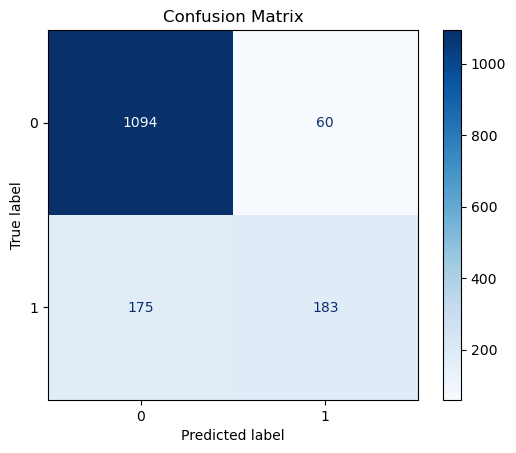

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [26]:
TP = conf_matrix[1, 1]  # Correctly predicted positives
FN = conf_matrix[1, 0]  # Missed positives
TPR = TP / (TP + FN)
print(f"True Positive Rate: {TPR:.2f}")


True Positive Rate: 0.51


## Feature importances
Recall that to obtain the categorical feature importances, we have to work our way backward through the modelling pipeline to associate the feature importances with their original input variables, not the one-hot encoded ones. We don't need to do this for the numeric variables because we didn't modify their names in any way.
Remember we went from categorical features to one-hot encoded features, using the 'cat' column transformer.

Let's get all of the feature importances and associate them with their transformed features

### Extract the feature importances

In [27]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

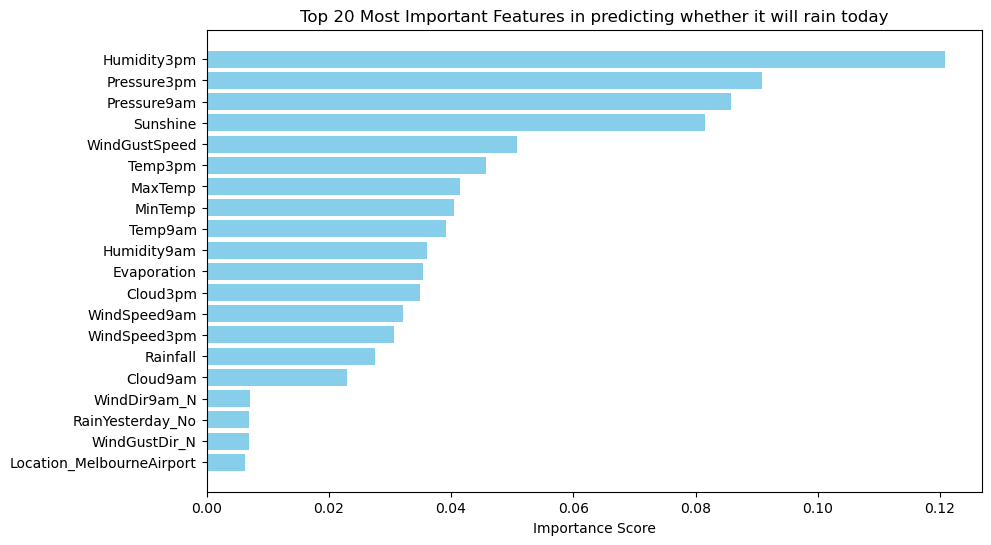

In [28]:
# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

N = 20  # Change this number to display more or fewer features

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

## Logistic Regression Model
### Update the pipeline and the parameter grid 

In [29]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# Update the estimator in GridSearchCV
grid_search.estimator = pipeline

# Define new grid
param_grid = {'classifier__solver': ['liblinear'],
              'classifier__penalty': ['l1', 'l2'],
              'classifier__class_weight': [None, 'balanced']}

grid_search.param_grid = param_grid

# Fit new model
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

### Compare the results to your previous model

              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



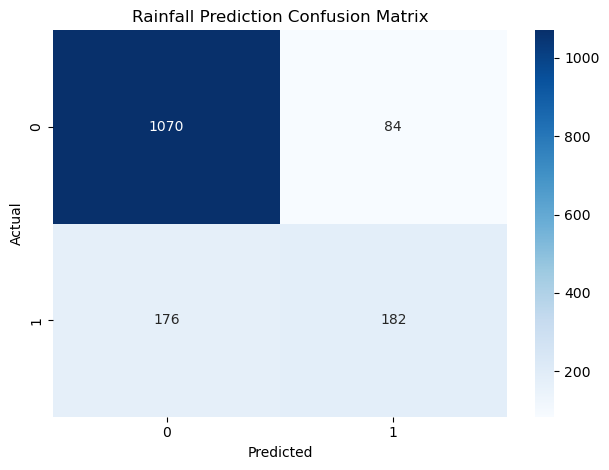

In [30]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Rainfall Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

## Conclusion
In this project, we successfully built and evaluated a machine learning model to predict rainfall using historical weather data. By performing feature engineering, model selection, hyperparameter tuning, and performance evaluation, we optimized our classifier to make accurate predictions.

**Key Takeaways**:
- Feature Engineering: We selected relevant meteorological features and addressed data leakage concerns to ensure robust predictions.
- Model Comparison: We analyzed the performance of Logistic Regression and Random Forest, observing trade-offs in accuracy and recall.
- Evaluation Metrics: Using confusion matrices, classification reports, and feature importance analysis, we gained insights into model strengths and weaknesses.
-Localized Modeling: We explored grouping locations for regional accuracy, refining our approach based on spatial weather patterns.

**Future Improvements**:
- Fine-tuning hyperparameters further to improve recall for rain prediction.
- Exploring additional classifiers like XGBoost or Gradient Boosting for enhanced accuracy.
- Integrating time-series forecasting techniques to capture long-term rainfall trends.

Overall, this project demonstrated the power of machine learning in weather forecasting, offering valuable insights for meteorologists, farmers, and climate analysts.